In [91]:
pip install pennylane

In [92]:
from PIL import Image
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter


"""To generate random bounding boxes."""
def compute_bounding_boxes(num_bouning_boxes,size:[]):

  bounding_boxes = []
  conf_score = []
  for i in range(num_bouning_boxes):
    num1 = random.randint(0, 350)
    num2 = random.randint(0, 350)

    bounding_boxes.append([num1, num2, num1+size[0], num2+size[1]])
    num = round(random.uniform(0.5,1),2)
    conf_score.append(num)

  return bounding_boxes,conf_score


"""To compute intersection between two bounding boxes."""
def compute_iou(box1, box2):
  x1, y1, x2, y2 = box1
  x1_p, y1_p, x2_p, y2_p = box2

  inter_x1 = max(x1, x1_p)
  inter_y1 = max(y1, y1_p)
  inter_x2 = min(x2, x2_p)
  inter_y2 = min(y2, y2_p)

  inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
  box1_area = (x2 - x1) * (y2 - y1)
  box2_area = (x2_p - x1_p) * (y2_p - y1_p)
  union_area = box1_area + box2_area - inter_area

  return inter_area / union_area if union_area > 0 else 0


"""To plot bounding boxes on black background"""
def drawing_bounding_boxes(boxes,score,plot_title):
  white_img = Image.new("RGB", (500, 500), "black")
  white_img = np.array(white_img)
  count = 0
  for i in boxes:
    x_min, y_min, x_max, y_max = i
    cv2.rectangle(white_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
    cv2.putText(white_img, str(score[count])+ str(count), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    count = count+1

  plt.figure(figsize=(12, 8))
  plt.imshow(white_img)
  plt.axis("off")
  plt.title(plot_title)
  plt.show()

"""Generation of all possoble 1's and 0's in array form."""
def generate_binary_array(n):
  max_number = 2**n
  binary_array = []
  for i in range(max_number):
    binary = format(i, f'0{n}b')
    binary_arr = [int(bit) for bit in list(binary)]
    binary_array.append(binary_arr)
  return np.array(binary_array)

In [93]:
def QUBO_solution(Q):

  QUBO_solution = {}
  x = []
  score = []
  n = len(Q)
  binary_array = generate_binary_array(n)
  energy_values = []
  for binary in binary_array:
    energy = np.dot(binary.T,np.dot(Q,binary))
    x.append(binary)
    score.append(energy)

  for arr, score in zip(x, score):
    QUBO_solution.setdefault("results", []).append({"array": arr, "score": score})

  QUBO_solution['results'] = sorted(QUBO_solution['results'], key=lambda x:x["score"])
  return QUBO_solution['results'][-1]['array']

In [94]:
def compute_Q_matrix (bounding_boxes, score, alpha, lambda_overlap, mu_sparsity):
  intersection = 0
  num_boxes = len(bounding_boxes)
  iou_matrix = np.zeros((num_boxes, num_boxes))

  for i in range(num_boxes):
    for j in range(num_boxes):
      if i != j :
        iou_matrix[i, j] = -round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)
        intersection = intersection + round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)
      if i ==j:
        iou_matrix[i, j] = -alpha * score[i]
      else:
        iou_matrix[i,j] = (lambda_overlap * compute_iou(bounding_boxes[i], bounding_boxes[j]) + mu_sparsity)
        intersection = intersection + round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)
  return iou_matrix, intersection

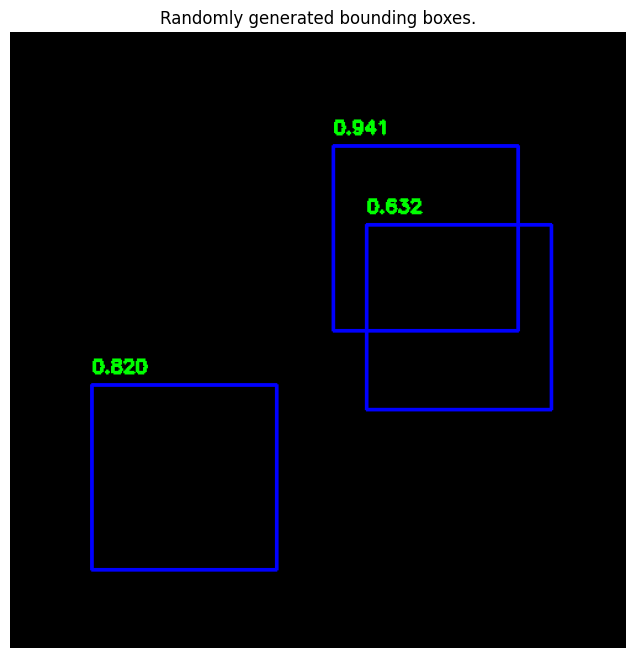

In [114]:
bounding_boxes, confidence_score = compute_bounding_boxes(3, [150,150])
drawing_bounding_boxes(bounding_boxes,confidence_score,"Randomly generated bounding boxes.")

[[262, 92, 412, 242], [66, 286, 216, 436]]


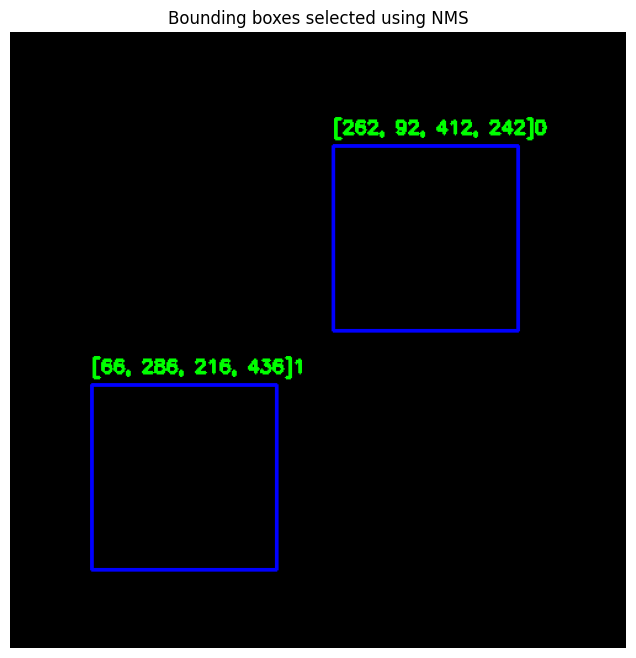

In [115]:
indices = cv2.dnn.NMSBoxes(bounding_boxes, confidence_score, score_threshold=0.5, nms_threshold=0.4)
NMS_boxes = [bounding_boxes[i] for i in indices.flatten()]
print(NMS_boxes)
hel = len(NMS_boxes)
drawing_bounding_boxes(NMS_boxes, NMS_boxes[:hel],"Bounding boxes selected using NMS")

#Panelty terms

# Confidence Scaling $α$

It will increase the values of a digonal entries which are confidence score of each bounding box.

$Q[i,i] = \alpha * ConfidenceScore[i]$

# Overlap Panelty $\lambda$

We will first check the overlapping panelty $\lambda$.

If two bounding boxes overlaps significantly

$Q[i,j] = -\lambda IOU[i,j]$


*   Higher $\lambda$ means stronger panelty for selecting overlaping bounding boxes.
*   Lower $\lambda$ means less restriction on selecting overlapping bounding boxes.

If $\lambda = 5$, then panelty for two windows overlap with iou = 0.5 is

$Q[i,j] = 0.5*-5 = -2.5$

This reduces the selection of both bounding boxes.

# Sparsity Panelty $\mu$

Encourage selecting fewer bounindg boxes, applies nagetive panelty on selecting many bounding boxes when they don't overlap.

*   Higher $\mu$ means QUBO will select fewer bounding boxes.
*   Lower $\mu$ allows more BB to be selected.


In [116]:
iou_matrix, intersection = compute_Q_matrix(bounding_boxes, confidence_score,5,3,1)
iou_matrix = iou_matrix / np.max(np.abs(iou_matrix))
pprint(iou_matrix)

array([[-0.87234043,  0.21276596,  0.21276596],
       [ 0.21276596, -1.        ,  0.40891711],
       [ 0.21276596,  0.40891711, -0.67021277]])


In [117]:
pprint(iou_matrix)
QUBO_solution = {}

x = []
score = []

for i in (0,1):
  for j in (0,1):
    for k in (0,1):
        res_matrix = [i,j,k]
        res_matrix = np.array(res_matrix)
        result = np.dot(iou_matrix,res_matrix)
        result = np.dot(res_matrix.T, result)
        x.append(res_matrix)
        score.append(result)

for arr, score in zip(x, score):
  QUBO_solution.setdefault("results", []).append({"array": arr, "score": score})

pprint(QUBO_solution)

QUBO_solution['results'] = sorted(QUBO_solution['results'], key=lambda x:x["score"])
pprint(QUBO_solution)

array([[-0.87234043,  0.21276596,  0.21276596],
       [ 0.21276596, -1.        ,  0.40891711],
       [ 0.21276596,  0.40891711, -0.67021277]])
{'results': [{'array': array([0, 0, 0]), 'score': np.float64(0.0)},
             {'array': array([0, 0, 1]),
              'score': np.float64(-0.6702127659574469)},
             {'array': array([0, 1, 0]), 'score': np.float64(-1.0)},
             {'array': array([0, 1, 1]),
              'score': np.float64(-0.8523785505805911)},
             {'array': array([1, 0, 0]),
              'score': np.float64(-0.8723404255319149)},
             {'array': array([1, 0, 1]),
              'score': np.float64(-1.1170212765957448)},
             {'array': array([1, 1, 0]),
              'score': np.float64(-1.4468085106382977)},
             {'array': array([1, 1, 1]),
              'score': np.float64(-0.8736551463252716)}]}
{'results': [{'array': array([1, 1, 0]),
              'score': np.float64(-1.4468085106382977)},
             {'array': array([1

In [118]:
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
import pennylane as qml
import numpy as np

NON MAXIMA SUPRESSION PROBLEM

$C = X^TQX$

Now to convert this problem into ising model we will take

$x_i = \frac{1-Z_i}{2}$

$C = \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} - \left( \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} \right) Z_i - \sum_{ij}\frac{Q_{ij}}{4}Z_j + \sum_{ij}\frac{Q_{ij}}{4}Z_iZ_j$

In [119]:
I = [[1,0],[0,1]]
Z = [[1,0],[0,-1]]

third_term = 0
for i in range(len(iou_matrix)):
    if i == 0:
      matrix = np.kron(Z,np.kron(I,I))
      third_term = third_term + (matrix*(iou_matrix[i][i]/2))
    if i == 1:
      matrix = np.kron(I,np.kron(Z,I))
      third_term = third_term + (matrix*(iou_matrix[i][i]/2))
    if i == 2:
      matrix = np.kron(I,np.kron(I,Z))
      third_term = third_term + (matrix*(iou_matrix[i][i]/2))

fourth_term = 0
for i in range(len(iou_matrix)):
  for j in range(len(iou_matrix)):
    if i!=j:
      if i == 0 and j == 1:
        matrix = np.kron(Z,np.kron(I,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 0 and j == 2:
        matrix = np.kron(Z,np.kron(I,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 2:
        matrix = np.kron(I,np.kron(Z,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 0:
        matrix = np.kron(I,np.kron(Z,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 0:
        matrix = np.kron(I,np.kron(I,Z))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 1:
        matrix = np.kron(I,np.kron(I,Z))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))

fifth_term = 0
for i in range(len(iou_matrix)):
  for j in range(len(iou_matrix)):
    if i!=j:
      if i == 0 and j == 1:
        matrix = np.kron(I,np.kron(Z,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 0 and j == 2:
        matrix = np.kron(I,np.kron(I,Z))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 2:
        matrix = np.kron(I,np.kron(I,Z))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 0:
        matrix = np.kron(Z,np.kron(I,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 0:
        matrix = np.kron(Z,np.kron(I,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 1:
        matrix = np.kron(I,np.kron(Z,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))

sixth_term = 0
for i in range(len(iou_matrix)):
  for j in range(len(iou_matrix)):
    if i!=j:
      if i == 0 and j == 1:
        matrix = np.kron(Z,np.kron(Z,I))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 0 and j == 2:
        matrix = np.kron(Z,np.kron(I,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 2:
        matrix = np.kron(I,np.kron(Z,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 0:
        matrix = np.kron(Z,np.kron(Z,I))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 0:
        matrix = np.kron(Z,np.kron(I,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 1:
        matrix = np.kron(I,np.kron(Z,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))

result_matix = -third_term-fourth_term-fifth_term+sixth_term
print(result_matix)

[[ 0.85405208  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.18383932  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -0.14594792  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.00167353  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.01828834  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.26296919
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.59275643  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.01960306]]


Now we compute this using quanthum circuit.

Quantum circuit mainly contains 3 gates. Z gate on a single qubit then ZZ gate which will be CNOT-Z-CNOT gate and X gate to all the qubits. Let us see how we can compute it.

In [120]:
def construct_Z_term(q1,Q_matrix_entry,beta):
  qml.RZ(Q_matrix_entry*beta,wires=q1)

def construct_ZZ(q1,q2,Q_matrix_entry,gamma):
  qml.CNOT(wires=[q1,q2])
  qml.RZ(2*Q_matrix_entry*gamma,wires=q2)
  qml.CNOT(wires=[q1,q2])

def construct_mixer_x_gate(q1,beta):
  qml.RX(2*beta, wires=q1)

We want to construct

$C = \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} - \left( \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} \right) Z_i - \sum_{ij}\frac{Q_{ij}}{4}Z_j + \sum_{ij}\frac{Q_{ij}}{4}Z_iZ_j$

But problem is we don't know in which order we have to apply this gates. So as usual we will first go with the order which is given.

In [121]:
def compute_cost_hamiltonian(Q_matrix, beta, gamma):
  dev = qml.device('default.qubit', wires = len(Q_matrix))
  @qml.qnode(dev)
  def cost_hamiltonian_circuit():
    for i in range(len(Q_matrix)):
      construct_Z_term(i, -Q_matrix[i][i]/2, gamma)
    for i in range(len(Q_matrix)):
      for j in range(len(Q_matrix)):
        if i!=j:
          construct_Z_term(i, -Q_matrix[i][j]/4, gamma)

    for i in range(len(Q_matrix)):
      for j in range(len(Q_matrix)):
        if i!=j:
          construct_Z_term(j, -Q_matrix[i][j]/4, gamma)

    for i in range(len(Q_matrix)):
      for j in range(len(Q_matrix)):
        if i!=j:
          construct_ZZ(i,j,Q_matrix[i][j]/4, gamma)

    for i in range(len(Q_matrix)):
      construct_mixer_x_gate(i, beta)

    return qml.state()
  return cost_hamiltonian_circuit

qc = compute_cost_hamiltonian(iou_matrix, np.pi / 3, np.pi / 3)
print(qml.draw(qc)())

0: ──RZ(0.46)──RZ(-0.06)──RZ(-0.06)──RZ(-0.06)──RZ(-0.06)─╭●───────────╭●─╭●───────────╭●─╭X ···
1: ──RZ(0.52)──RZ(-0.06)──RZ(-0.11)──RZ(-0.06)──RZ(-0.11)─╰X──RZ(0.11)─╰X─│────────────│──╰● ···
2: ──RZ(0.35)──RZ(-0.06)──RZ(-0.11)──RZ(-0.06)──RZ(-0.11)─────────────────╰X──RZ(0.11)─╰X─── ···

0: ··· ──RZ(0.11)─╭X─────────────────╭X──RZ(0.11)─╭X──RX(2.09)────────────────────────┤  State
1: ··· ───────────╰●─╭●───────────╭●─│────────────│──╭X─────────RZ(0.21)─╭X──RX(2.09)─┤  State
2: ··· ──────────────╰X──RZ(0.21)─╰X─╰●───────────╰●─╰●──────────────────╰●──RX(2.09)─┤  State


In [122]:
from collections import Counter

def compute_QAOA_circuit(Q_matrix, beta, gamma):
  assert(len(beta) == len(gamma))
  p = len(beta)
  dev = qml.device('default.qubit', wires = len(Q_matrix), shots=1000)
  @qml.qnode(dev)
  def QAOA_circuit():
    for i in range(len(Q_matrix)):
      qml.Hadamard(wires=i)
    for k in range(p):
      for i in range(len(Q_matrix)):
          construct_Z_term(i, -Q_matrix[i][i]/2, gamma[k])
      for i in range(len(Q_matrix)):
        for j in range(len(Q_matrix)):
          if i!=j:
            construct_Z_term(i, -Q_matrix[i][j]/4, gamma[k])

      for i in range(len(Q_matrix)):
        for j in range(len(Q_matrix)):
          if i!=j:
            construct_Z_term(j, -Q_matrix[i][j]/4, gamma[k])

      for i in range(len(Q_matrix)):
        for j in range(len(Q_matrix)):
          if i!=j:
            construct_ZZ(i,j,Q_matrix[i][j]/4, gamma[k])

      for i in range(len(Q_matrix)):
        construct_mixer_x_gate(i, beta[k])
    return qml.counts()
  return QAOA_circuit()

qc = compute_QAOA_circuit(iou_matrix, [np.pi / 3], [np.pi / 3])
for key, value in qc.items():
    print(f"{key}: {value}")

000: 95
001: 228
010: 169
011: 94
100: 130
101: 147
110: 104
111: 33


In [123]:
def NMS_objective(x,iou_matrix):
  detections = np.array([int(char) for char in x])
  result = np.dot(iou_matrix,detections)
  result = np.dot(detections.T, result)
  return result

In [124]:
def compute_NMS_energy(counts,iou_matrix):
  energy = 0
  total_counts = 0
  for meas, meas_count in counts.items():
    obj_for_meas = NMS_objective(meas,iou_matrix)
    energy += obj_for_meas * meas_count
    total_counts += meas_count
  return energy/total_counts

compute_NMS_energy(qc, iou_matrix)

np.float64(-0.8588371823067138)

In [125]:
def get_black_box_objective(iou_matrix, p):
  def f(theta):
    beta = theta[:p]
    gamma = theta[p:]
    counts = compute_QAOA_circuit(iou_matrix, beta, gamma)
    print(counts)
    return compute_NMS_energy(counts, iou_matrix)
  return f

In [126]:
p = 10
obj = get_black_box_objective(iou_matrix,p)
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.91069872, 1.2067517 , 0.88762696, 1.87679759, 0.9234699, 2.9864091, 0.5627165, 3.91827365, 0.672536, 1.9283765, 0.6351722, 1.92837364, 0.982736, 3.9182736  ])
# init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.82730, 0.82736 ])

res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
res_sample

{np.str_('000'): np.int64(64), np.str_('001'): np.int64(158), np.str_('010'): np.int64(157), np.str_('011'): np.int64(47), np.str_('101'): np.int64(285), np.str_('110'): np.int64(190), np.str_('111'): np.int64(99)}
{np.str_('000'): np.int64(80), np.str_('001'): np.int64(53), np.str_('010'): np.int64(170), np.str_('011'): np.int64(67), np.str_('100'): np.int64(9), np.str_('101'): np.int64(286), np.str_('110'): np.int64(209), np.str_('111'): np.int64(126)}
{np.str_('000'): np.int64(24), np.str_('001'): np.int64(72), np.str_('010'): np.int64(7), np.str_('011'): np.int64(134), np.str_('100'): np.int64(4), np.str_('101'): np.int64(85), np.str_('110'): np.int64(8), np.str_('111'): np.int64(666)}
{np.str_('000'): np.int64(71), np.str_('001'): np.int64(93), np.str_('010'): np.int64(3), np.str_('011'): np.int64(147), np.str_('100'): np.int64(10), np.str_('101'): np.int64(52), np.str_('110'): np.int64(4), np.str_('111'): np.int64(620)}
{np.str_('000'): np.int64(174), np.str_('001'): np.int64(2),

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1888920389854585
       x: [ 2.025e+00  2.187e+00 ...  2.285e+00  3.617e+00]
    nfev: 194
   maxcv: 0.0

Below code computes random bounding box, and using NMS algorithm suppression takes place. Using same IOU and confidence score $H_C$ is computed to run on QAOA circuit. After optimization of QAOA macimum number of measurements shows final result using QAOA. You can see that detections using QAOA and NMS are some.

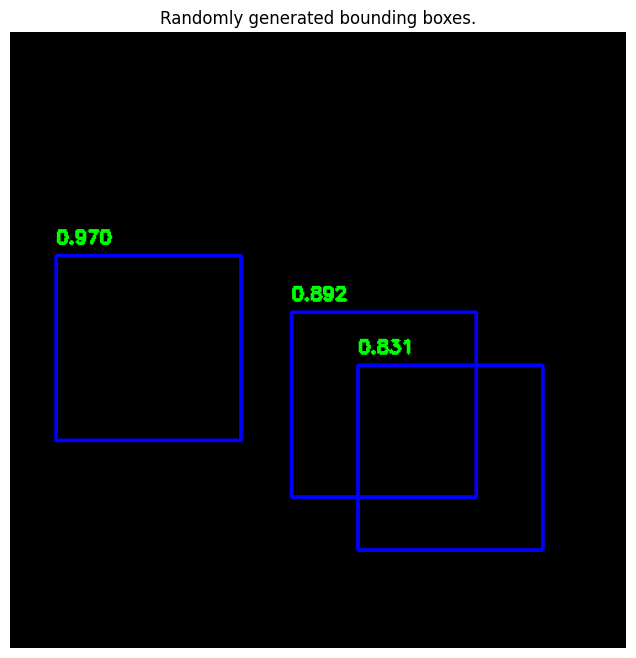

array([[-1.        ,  0.20618557,  0.20618557],
       [ 0.20618557, -0.8556701 ,  0.38914498],
       [ 0.20618557,  0.38914498, -0.91752577]])
[[37, 181, 187, 331], [228, 227, 378, 377]]


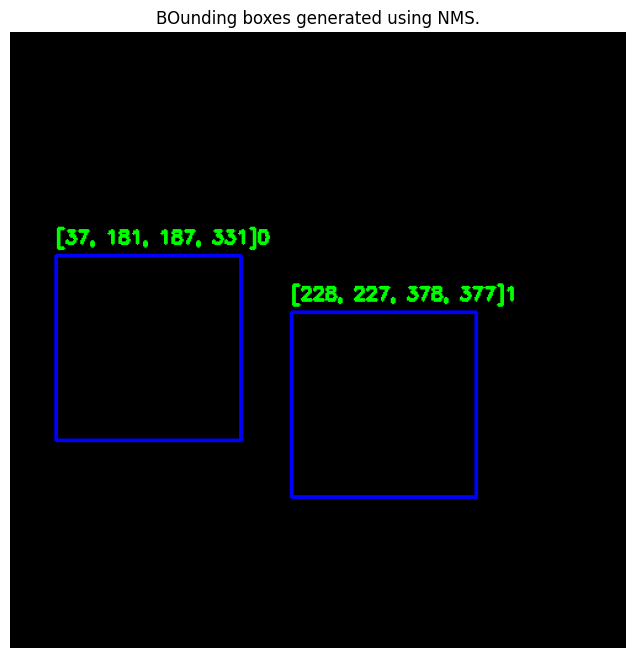

{np.str_('000'): np.int64(59), np.str_('001'): np.int64(100), np.str_('010'): np.int64(123), np.str_('011'): np.int64(231), np.str_('100'): np.int64(20), np.str_('101'): np.int64(151), np.str_('110'): np.int64(197), np.str_('111'): np.int64(119)}
{np.str_('000'): np.int64(177), np.str_('001'): np.int64(64), np.str_('010'): np.int64(36), np.str_('011'): np.int64(273), np.str_('100'): np.int64(15), np.str_('101'): np.int64(152), np.str_('110'): np.int64(171), np.str_('111'): np.int64(112)}
{np.str_('000'): np.int64(33), np.str_('001'): np.int64(64), np.str_('010'): np.int64(80), np.str_('011'): np.int64(116), np.str_('100'): np.int64(49), np.str_('101'): np.int64(47), np.str_('110'): np.int64(21), np.str_('111'): np.int64(590)}
{np.str_('000'): np.int64(81), np.str_('001'): np.int64(26), np.str_('010'): np.int64(45), np.str_('011'): np.int64(123), np.str_('100'): np.int64(28), np.str_('101'): np.int64(56), np.str_('110'): np.int64(28), np.str_('111'): np.int64(613)}
{np.str_('000'): np.i

In [ ]:
bounding_boxes, confidence_score = compute_bounding_boxes(3, [150,150])
drawing_bounding_boxes(bounding_boxes,confidence_score,"Randomly generated bounding boxes.")

iou_matrix, interaction = compute_Q_matrix(bounding_boxes, confidence_score,5,3,1)
iou_matrix = iou_matrix / np.max(np.abs(iou_matrix))
iou_matrix = np.array(iou_matrix)

pprint(iou_matrix)

indices = cv2.dnn.NMSBoxes(bounding_boxes, confidence_score, score_threshold=0.5, nms_threshold=0.4)
selected_boxes = [bounding_boxes[i] for i in indices.flatten()]
print(selected_boxes)
hel = len(selected_boxes)
drawing_bounding_boxes(selected_boxes, selected_boxes[:hel], "BOunding boxes generated using NMS.")

p = 10
obj = get_black_box_objective(iou_matrix,p)
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.91069872, 1.2067517 , 0.88762696, 1.87679759, 0.9234699, 2.9864091, 0.5627165, 3.91827365, 0.672536, 1.9283765, 0.6351722, 1.92837364, 0.982736, 3.9182736  ])
# init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.82730, 0.82736 ])

res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
res_sample

{np.str_('000'): np.int64(134), np.str_('001'): np.int64(133), np.str_('010'): np.int64(109), np.str_('011'): np.int64(146), np.str_('100'): np.int64(112), np.str_('101'): np.int64(105), np.str_('110'): np.int64(124), np.str_('111'): np.int64(137)}
{np.str_('000'): np.int64(116), np.str_('001'): np.int64(162), np.str_('010'): np.int64(184), np.str_('011'): np.int64(108), np.str_('100'): np.int64(146), np.str_('101'): np.int64(106), np.str_('110'): np.int64(123), np.str_('111'): np.int64(55)}
{np.str_('000'): np.int64(142), np.str_('001'): np.int64(130), np.str_('010'): np.int64(119), np.str_('011'): np.int64(129), np.str_('100'): np.int64(124), np.str_('101'): np.int64(110), np.str_('110'): np.int64(107), np.str_('111'): np.int64(139)}
{np.str_('000'): np.int64(149), np.str_('001'): np.int64(129), np.str_('010'): np.int64(129), np.str_('011'): np.int64(118), np.str_('100'): np.int64(120), np.str_('101'): np.int64(120), np.str_('110'): np.int64(108), np.str_('111'): np.int64(127)}
{np.s

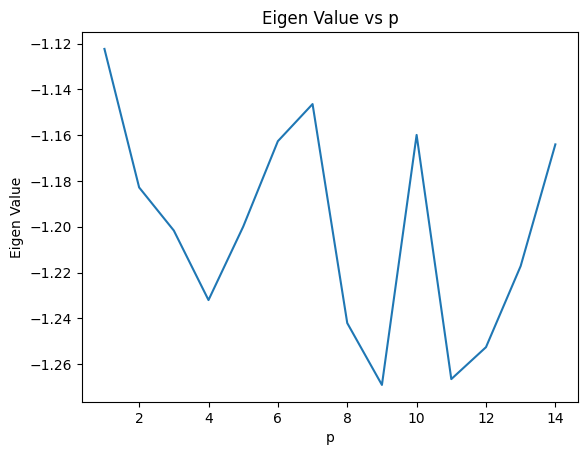

In [128]:
p_size = []
eigen_value = []

for i in range(1,15):
  init_point = random_array = np.random.rand(2*i)
  p_size.append(i)

  obj = get_black_box_objective(iou_matrix,i)

  res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
  eigen_value.append(res_sample.fun)

plt.plot(p_size, eigen_value)
plt.xlabel('p')
plt.ylabel('Eigen Value')
plt.title('Eigen Value vs p')
plt.show()
  # res_sample